In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-prime-movies-and-tv-shows/amazon_prime_titles.csv


**Import Libraies**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors

**Data Load**

In [3]:
data= pd.read_csv('/kaggle/input/amazon-prime-movies-and-tv-shows/amazon_prime_titles.csv')

In [4]:
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,"March 30, 2021",2014,NaN,113 min,"Comedy, Drama",A small fishing village must procure a local d...
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,"March 30, 2021",2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...
2,s3,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,"March 30, 2021",2017,NaN,74 min,"Action, Drama, Suspense",After a man discovers his wife is cheating on ...
3,s4,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,"March 30, 2021",2014,NaN,69 min,Documentary,"Pink breaks the mold once again, bringing her ..."
4,s5,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,"March 30, 2021",1989,NaN,45 min,"Drama, Fantasy",Teenage Matt Banting wants to work with a famo...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9668 entries, 0 to 9667
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       9668 non-null   object
 1   type          9668 non-null   object
 2   title         9668 non-null   object
 3   director      7585 non-null   object
 4   cast          8435 non-null   object
 5   country       672 non-null    object
 6   date_added    155 non-null    object
 7   release_year  9668 non-null   int64 
 8   rating        9331 non-null   object
 9   duration      9668 non-null   object
 10  listed_in     9668 non-null   object
 11  description   9668 non-null   object
dtypes: int64(1), object(11)
memory usage: 906.5+ KB


**Preprocessing**

In [6]:
data.fillna('', inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9668 entries, 0 to 9667
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       9668 non-null   object
 1   type          9668 non-null   object
 2   title         9668 non-null   object
 3   director      9668 non-null   object
 4   cast          9668 non-null   object
 5   country       9668 non-null   object
 6   date_added    9668 non-null   object
 7   release_year  9668 non-null   int64 
 8   rating        9668 non-null   object
 9   duration      9668 non-null   object
 10  listed_in     9668 non-null   object
 11  description   9668 non-null   object
dtypes: int64(1), object(11)
memory usage: 906.5+ KB


**EDA**

In [8]:
data['release_year'] = pd.to_numeric(data['release_year'], errors='coerce')

In [9]:
release_year_data = data.dropna(subset=['release_year'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


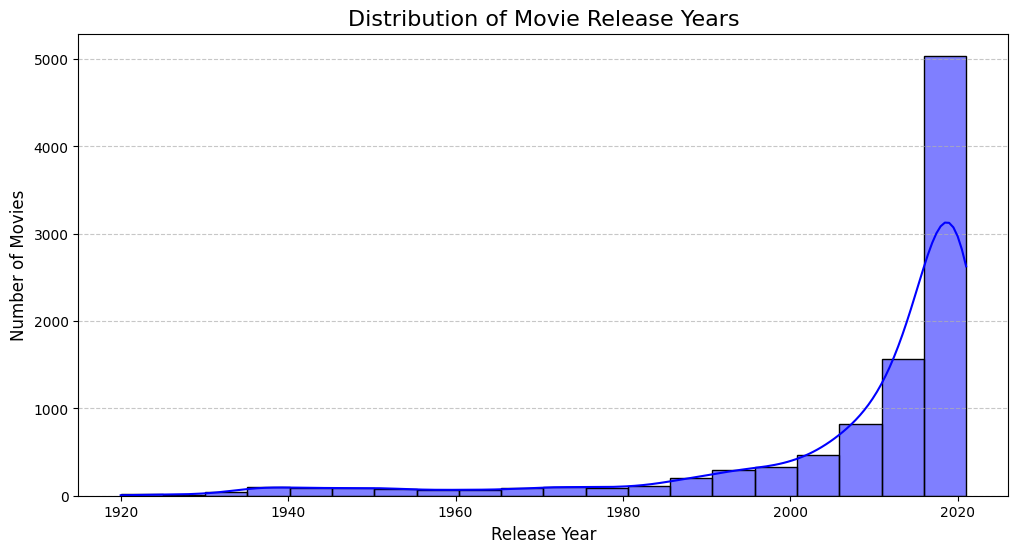

In [10]:
plt.figure(figsize=(12, 6))
sns.histplot(release_year_data['release_year'], bins=20, kde=True, color='blue')
plt.title('Distribution of Movie Release Years', fontsize=16)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:
genres = data['listed_in'].dropna().str.split(', ')
all_genres = [genre for sublist in genres for genre in sublist]
genre_counts = Counter(all_genres)

In [12]:
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

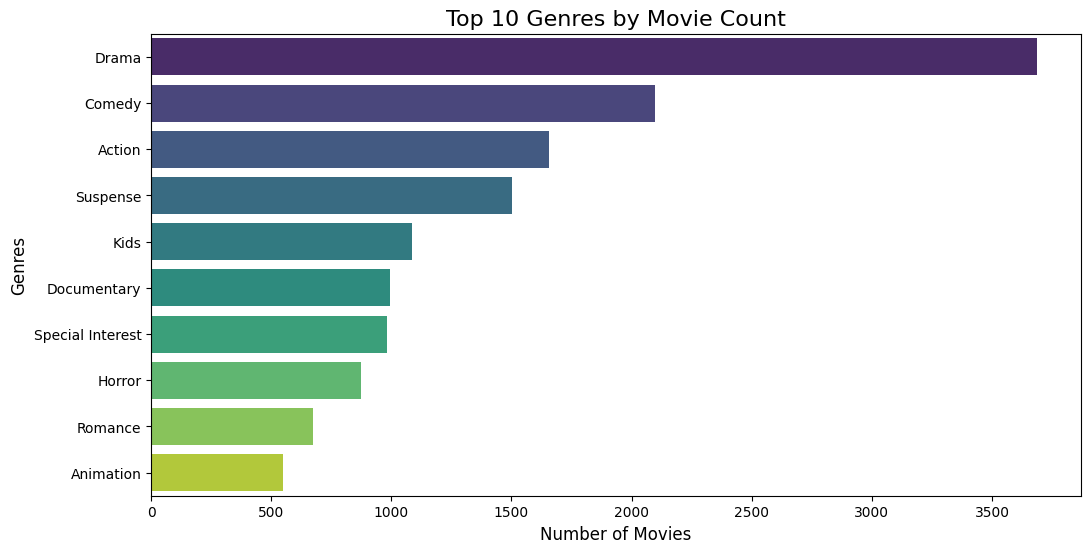

In [13]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Genre', data=genre_df.head(10), palette='viridis')
plt.title('Top 10 Genres by Movie Count', fontsize=16)
plt.xlabel('Number of Movies', fontsize=12)
plt.ylabel('Genres', fontsize=12)
plt.show()

****
Combine Metadata Into a Single String for Each Movie

In [14]:
data['metadata'] = data['director'] + ' ' + data['cast'] + ' ' + data['listed_in'] + ' ' + data['description']

**Vectorization**

In [15]:
vectorizer = CountVectorizer(stop_words='english')
feature_matrix = vectorizer.fit_transform(data['metadata'])

**KNN**

In [16]:
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(feature_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [17]:
def recommend_movies_knn(title, data=data, knn=knn, feature_matrix=feature_matrix, top_n=10):
   
    indices = pd.Series(data.index, index=data['title']).drop_duplicates()
    if title not in indices:
        return f"Movie '{title}' not found in the dataset."

    idx = indices[title]

    
    distances, indices = knn.kneighbors(feature_matrix[idx], n_neighbors=top_n+1)

   
    recommended_movies = data['title'].iloc[indices.flatten()]
    recommended_movies = recommended_movies[1:]  

    return recommended_movies

In [18]:
movie_name = "The Grand Seduction"  
recommended = recommend_movies_knn(movie_name)
print(f"Movies recommended for '{movie_name}':\n{recommended}")

Movies recommended for 'The Grand Seduction':
4319                    Kadaram Kondan
5966                        Chittibabu
604                  The Indian Doctor
7404                    Gunde Pranayam
8274                  Raja Chinna Roja
2267                    Hamish Macbeth
2092    Invasion of the Body Snatchers
1407                      Oru Kai Osai
2638             Doctor Blood's Coffin
508                     The North Star
Name: title, dtype: object
